# This Notebook reads in `alldata` files from the **Rat Trap** for a given directory and processes them

### This is an example notebook which has been set up to process K-alpha XES data collected on 4 Mn compounds (Mn Metal, MnO, Mn2O3, and MnO2). The data used in this example was taken in July 2022.

In [1]:
# Authors: Charles Cardot, Samantha Tetef, Diwash Dhakal, and Jared Abramson
# Last Updated: August 2022

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from utils.basic_funcs import get_spectra
from utils.basic_funcs import subtract_linear_background
from utils.basic_funcs import normalize
from utils.basic_funcs import plottrim

The **Rat Trap** is the name of a lab based x-ray spectrometer which belongs to the Seidler research group at UW. It can be used for measuring both x-ray emission spectrosocpy (XES) and x-ray absorption spectroscopy (XAS) data. The directory structure of a particular experiment generally looks something like
```
Mn Data  
│
└───Mn Metal
│   │
│   └───Mn Metal_1
│   │   │   event_log_Mn Metal_1.txt
│   |   │   Mn Metal1_alldata_0.txt
│   |   │   scan_definition_Mn Metal_1_0.txt
│   │   │   Mn Metal_0__EDX_0.txt
│   │   │   Mn Metal_0__EDX_1.txt
│   |   │   ...
│   |
│   └───Mn Metal_2
│       │   event_log_Mn Metal_2.txt
│       │   Mn Metal2_alldata_0.txt
│       │   scan_definition_Mn Metal_2_0.txt
│       │   Mn Metal_0__EDX_0.txt
│       │   Mn Metal_0__EDX_1.txt
│       │   ...
│   
└───Mn(II)
│   │
│   └───Mn (II)_1
│   │   │   ...
│   │
│   └───Mn (II)_2
│   │   │   ...
│   
└───Mn(III)
│   │
│   ...
```

Please note that this is just an example, and the file structure of your experiment folder will be specific to how it was set up during data collection. Here we used the first batch of runs (all the '_1' folders) to calibrate the detector and the second batch of runs (all the '_2' folder) to take the data we actually care about. Specifically, we want to read in the files


 - '_Batch Folder_'\_alldata\_'_Run Number_'.txt
 - (ex: Mn Metal2_alldata_0.txt)

For some compounds there will be multiple runs, in which case there will be multiple `alldata` files to read in. Let's start by just plotting the spectra from the first run of Mn(II).

### Plot spectra from the first run of Mn(II).

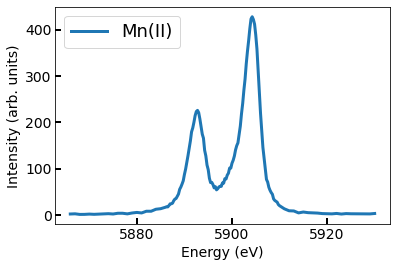

In [2]:
data_folder_path = Path.cwd() / "Data" / "Mn(II)" / "Mn(II)_2"
spectra = get_spectra(data_folder_path, runs=[0])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(spectra[0], spectra[1], label='Mn(II)', linewidth=3)
ax.legend(fancybox=True, loc=2, fontsize=18)
ax.tick_params(direction='in', width=2, length=6, labelsize=14)
ax.set_xlabel('Energy (eV)', fontsize=14)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
plt.show()

It is worth repeating that in this example we are only plotting data from the runs in second batch folder, as this is where the data we care about lives.

The object which gets returned from the get_spectra() function is a 2d numpy array of the form

```
spectra = [
    [x_values],
    [y_values]
]
```

There are only two runs in this batch, let's try including both of them. To do this we can either change the list in the runs argument to be

```
runs = [0,1]
```

or just set

```
runs = 'all'
```

### Plot spectra from all runs of Mn(II)

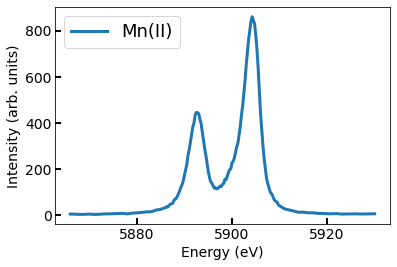

In [3]:
data_folder_path = Path.cwd() / "Data" / "Mn(II)" / "Mn(II)_2"
spectra = get_spectra(data_folder_path, runs='all')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(spectra[0], spectra[1], label='Mn(II)', linewidth=3)
ax.legend(fancybox=True, loc=2, fontsize=18)
ax.tick_params(direction='in', width=2, length=6, labelsize=14)
ax.set_xlabel('Energy (eV)', fontsize=14)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
plt.show()

Including multiple runs just returns a 2d numpy array 'spectra' which is a sum of all the runs. Notice here that when we include 2 runs, the peaks roughly double in intensity.

Now lets do some basic processing on the raw spectra. Specifically, let's use the functions stored in the `basic_funcs.py` file in the utils folder to background subtract, normalize, and change the x range of the spectra array.

### Do some basic processing on the raw spectra

In [4]:
spectra = subtract_linear_background(spectra, left_roi=(5866, 5871), right_roi=(5925, 5930))
spectra = normalize(spectra) 
x_Ka1_peak_pos = spectra[0][np.argmax(spectra[1])]
# This step is mainly aesthetic, for plotting
spectra = plottrim(spectra, -25, 10, relative_position=x_Ka1_peak_pos)

### A small aside on background subtraction

The exact method you want to use for background subtraction will change depending on the characteristics of your spectra. For K-alpha, our statistics are quite good, and we don't expect to have a steeply sloped background, therefore it shouldn't matter much whether we model the background as a constant function or a linear one. 

For Mn spectra in this example we have a decent range of data both above and below the main Kalpha peaks, so we will use the `subtract_linear_background` function. We picked two small ranges of data where the signal is almost entirely flat, one above and one below the main peaks. The function averages the x and y values of the spectra in both regions, giving us two points, which are then used to define a line which represents the linear background. Finally the background line is subtracted it from the overall spectra. See the figure below.

<img src="Figures/LinearBkgSubtraction_example.jpg" alt="Linear background example" width="800"/>

There is also a `subtract_constant_background` function which is available. If you are uncertain about what to do for background stubtraction, ask someone else in the lab who has more experience with the Rat Trap.

### Plot the processed spectra

For this one let's try to make it a bit nicer using some built in functionality of matplotlib. Feel free to mess with the parameters to see what they do.

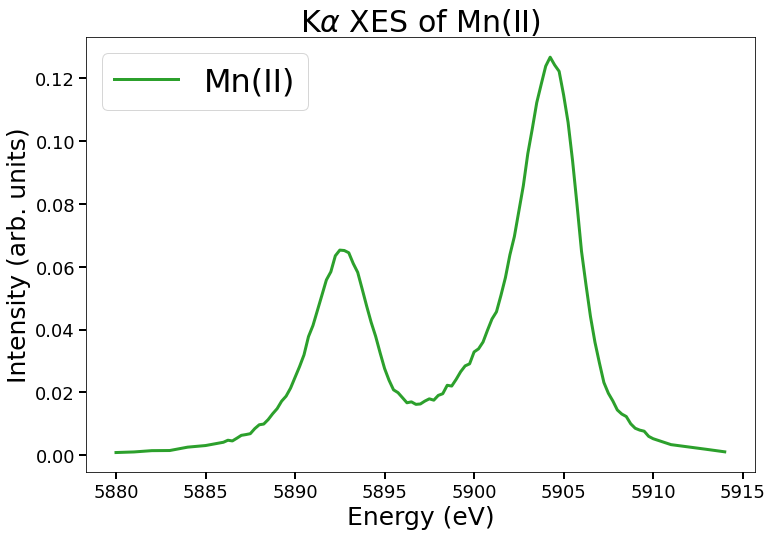

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(spectra[0], spectra[1], color=plt.cm.tab10(2), linewidth=3,
        label="Mn(II)")

ax.set_title(r'K${\alpha}$ XES of Mn(II)', fontsize=30)
ax.set_xlabel('Energy (eV)', fontsize=25)
ax.set_ylabel('Intensity (arb. units)', fontsize=25)
ax.tick_params(direction='out', width=2, length=7, labelsize=18)
ax.legend(fontsize=32, loc=2, fancybox=True)

plt.savefig('Figures/Mn(II)_processed.png', bbox_inches='tight', dpi=400)
plt.show()

### Final Plot

Now let's put everything together and write a workflow to make one final plot which shows the processed spectra for all four of the Mn materials that we took data for.

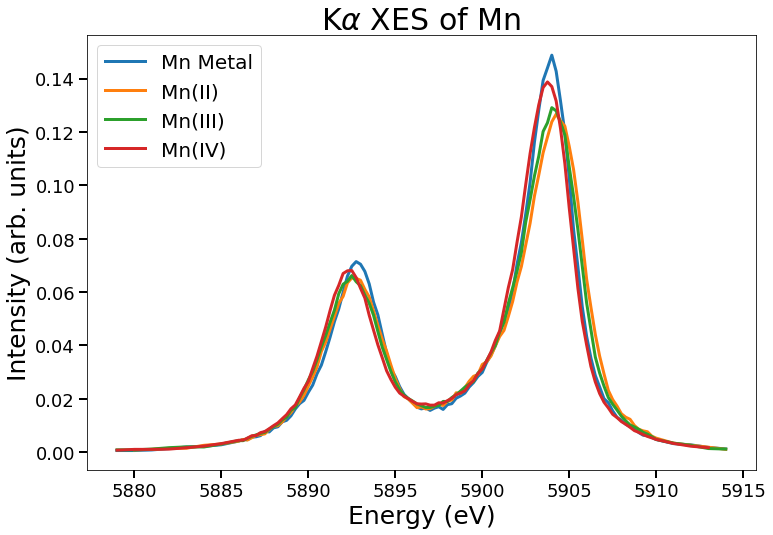

In [6]:
compound_names = ["Mn Metal", "Mn(II)", "Mn(III)", "Mn(IV)"]

def process_Mn_spectra(arr):
    arr = subtract_linear_background(arr, left_roi=(5866,5871), right_roi=(5925,5930))
    arr = normalize(arr)
    x_Ka1_peak_pos = arr[0][np.argmax(arr[1])]
    arr = plottrim(arr, -25, 10, relative_position=x_Ka1_peak_pos)    
    return arr


fig, ax = plt.subplots(figsize=(12, 8))
for compound in compound_names:
    data_folder_path = Path.cwd() / "Data" / compound / str(compound + "_2")
    
    spectra = get_spectra(data_folder_path, runs='all')
    spectra = process_Mn_spectra(spectra)
    ax.plot(spectra[0], spectra[1], label=compound, linewidth=3)

ax.set_title(r'K${\alpha}$ XES of Mn', fontsize=30)
ax.set_xlabel('Energy (eV)', fontsize=25)
ax.set_ylabel('Intensity (arb. units)', fontsize=25)
ax.tick_params(direction='out', width=2, length=8, labelsize=18)
ax.legend(fontsize=20, loc=2, fancybox=True)

plt.savefig('Figures/All_Mn.png', bbox_inches='tight', dpi=600)
plt.show()